# 라이브러리 불러오기


In [ ]:
import numpy as np
import pandas as pd
import gc
import math
import os
import sys
import time
import matplotlib.pyplot as plt
from dateutil import parser
from tqdm import tqdm
import datetime
import copy
import warnings
warnings.filterwarnings("ignore")

# 데이터 처리

#train.csv : 훈련용 데이터

3년(Day 0~1094) 동안의 기상 데이터, 발전량(Target)데이터

칼럼 Day, Hour, Minute, DHI, DNI, WS, RH, T, Target

문제 용어
- DHI : Diffuse Horizontal Irradiance/ 수평면 산란일사량 (W/m^2)
- DNI : Direct Normal Irradiance /직달일사량 ==> 실제 태양에너지 시스템에서 필수 (W/m^2)
- WS : Wind Speed / 풍속 (m/s)
- RH : Relative Humidity / 상대습도 (%)
- T : Temparature / 기온 (C)
- Target : 태양광 발전량 (kW)

첫 날(0번째)의 초반 시간대(해가 뜨기 전) 발전량은 0 + 하루종일의 데이터를 보면 발전량은 누적이 아닌 해당 시간대의 발전량

DNI 값이 0 보다 커야지(일사량 이므로 해가 뜬다는 뜻으로 받아 들이자) 발전이 시작된다.

계절에 따라서도 일사량이 변할 수 있기 때문에 계절성(seasonality)도 고려를 하면 좋을 것 같음

In [ ]:
# train set 확인
path = '/content/drive/MyDrive/study/solarpower/data'
train = pd.read_csv(path  + "/train/train.csv")
print(train.shape)
train.head() 

(52560, 9)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int64  
 1   Hour    52560 non-null  int64  
 2   Minute  52560 non-null  int64  
 3   DHI     52560 non-null  int64  
 4   DNI     52560 non-null  int64  
 5   WS      52560 non-null  float64
 6   RH      52560 non-null  float64
 7   T       52560 non-null  int64  
 8   TARGET  52560 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


In [ ]:
train.describe()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,547.000000,11.500000,15.000000,64.344121,234.792371,2.456033,56.793102,9.279928,17.790630
std,316.102148,6.922252,15.000143,103.897125,349.684583,1.426874,22.052875,10.179741,25.759955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.590000,-19.000000,0.000000
25%,273.000000,5.750000,0.000000,0.000000,0.000000,1.400000,39.697500,1.000000,0.000000
50%,547.000000,11.500000,15.000000,0.000000,0.000000,2.200000,57.600000,9.000000,0.000000
75%,821.000000,17.250000,30.000000,87.000000,469.000000,3.200000,72.770000,17.000000,32.089890
max,1094.000000,23.000000,30.000000,528.000000,1059.000000,12.000000,100.000000,35.000000,99.913939


In [ ]:
train.isnull().sum() # NULL 값이 없음을 확인할 수 있다.

Day       0
Hour      0
Minute    0
DHI       0
DNI       0
WS        0
RH        0
T         0
TARGET    0
dtype: int64

Target과 상관계수가 높은 순(절대치 기준)

DNI, RH, DHI, T / 나머지는 굳이 없어도 될 것 같기도 하다.

\+ 잘생각해보면 Hour 와 Minute을 모두 고려할 필요는 없다, 합해줘도 되고 Minute을 빼도 될 것

In [ ]:
# 피어슨 상관계수 이용 상관분석
corr = train.corr(method = "pearson")
corr

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
Day,1.000000,0.000000,0.000000,-0.027802,0.021901,0.038477,-0.127688,0.072897,-0.002505
Hour,0.000000,1.000000,0.000000,0.029905,-0.018094,-0.055903,-0.084275,0.105528,0.003817
Minute,0.000000,0.000000,1.000000,-0.001305,-0.000997,-0.009522,0.008839,-0.007646,-0.000240
DHI,-0.027802,0.029905,-0.001305,1.000000,0.288294,0.203286,-0.478503,0.457813,0.666908
DNI,0.021901,-0.018094,-0.000997,0.288294,1.000000,0.219555,-0.611184,0.402460,0.833547
WS,0.038477,-0.055903,-0.009522,0.203286,0.219555,1.000000,-0.230035,0.027693,0.238521
RH,-0.127688,-0.084275,0.008839,-0.478503,-0.611184,-0.230035,1.000000,-0.532777,-0.677178
T,0.072897,0.105528,-0.007646,0.457813,0.402460,0.027693,-0.532777,1.000000,0.561990
TARGET,-0.002505,0.003817,-0.000240,0.666908,0.833547,0.238521,-0.677178,0.561990,1.000000


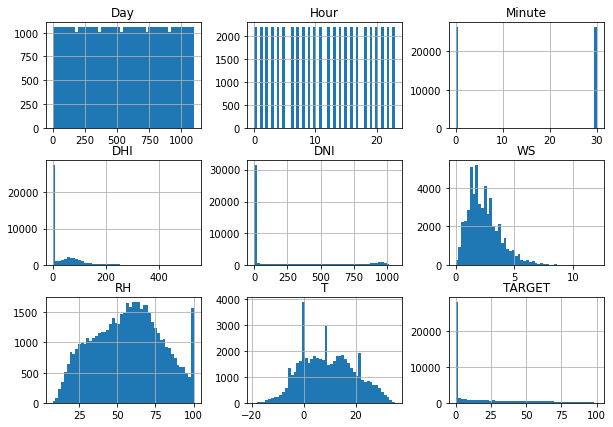

In [ ]:
#데이터 그려보기
train.hist(bins=50, figsize=(10,7))
plt.show()

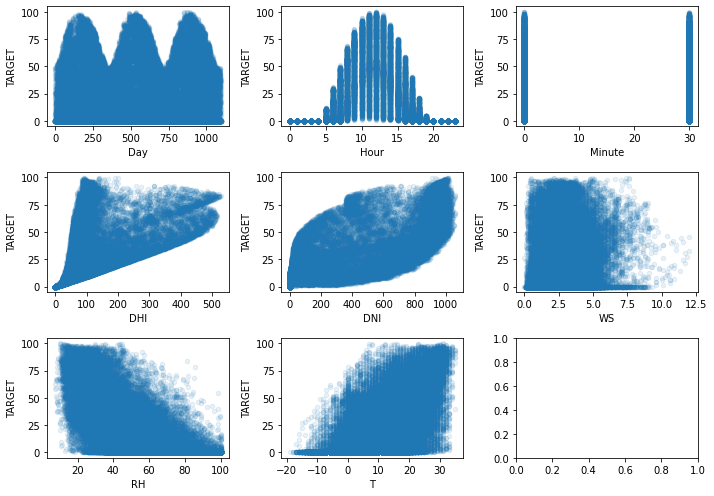

In [ ]:
# 산점도
fig, axes = plt.subplots(3, 3, figsize=(10,7))
train.plot(x='Day', y='TARGET', kind='scatter', alpha=0.1, ax=axes[0,0])
train.plot(x='Hour', y='TARGET', kind='scatter', alpha=0.1, ax=axes[0,1])
train.plot(x='Minute', y='TARGET', kind='scatter', alpha=0.1, ax=axes[0,2])
train.plot(x='DHI', y='TARGET', kind='scatter', alpha=0.1, ax=axes[1,0])
train.plot(x='DNI', y='TARGET', kind='scatter', alpha=0.1, ax=axes[1,1])
train.plot(x='WS', y='TARGET', kind='scatter', alpha=0.1, ax=axes[1,2])
train.plot(x='RH', y='TARGET', kind='scatter', alpha=0.1, ax=axes[2,0])
train.plot(x='T', y='TARGET', kind='scatter', alpha=0.1, ax=axes[2,1])

fig.tight_layout()